<a href="https://colab.research.google.com/github/neel26desai/cmpe258_transfer_learning_cv/blob/main/Supervised_Constructive_Loss_function_Vs_Softmax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
!pip install tensorflow-addons


In [40]:
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

Prepare data

In [51]:
num_classes = 10
input_shape = (32, 32, 3)


# Load the train and test data splits
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

# Display shapes of train and test datasets
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")


170498071/170498071 [==============================] - 2s 0us/step
x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


## Using Image data augmentation

In [53]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.02),
    ]
)

# Setting the state of the normalization layer.
data_augmentation.layers[0].adapt(x_train)

### Build encoder model

In [54]:
def create_encoder():
    resnet = keras.applications.ResNet50V2(
        include_top=False, weights=None, input_shape=input_shape, pooling="avg"
    )

    inputs = keras.Input(shape=input_shape)
    augmented = data_augmentation(inputs)
    outputs = resnet(augmented)
    model = keras.Model(inputs=inputs, outputs=outputs, name="cifar10-encoder")
    return model


encoder = create_encoder()
encoder.summary()

learning_rate = 0.001
batch_size = 265
hidden_units = 512
projection_units = 128
num_epochs = 10
dropout_rate = 0.5
temperature = 0.05

Model: "cifar10-encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 sequential_8 (Sequential)   (None, 32, 32, 3)         7         
                                                                 
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
Total params: 23564807 (89.89 MB)
Trainable params: 23519360 (89.72 MB)
Non-trainable params: 45447 (177.53 KB)
_________________________________________________________________


### Build Classification Model

In [55]:
def create_classifier(encoder, trainable=True):
    #this will let use control if we want to find tune the encoder model layers or mo
    for layer in encoder.layers:
        layer.trainable = trainable

    inputs = keras.Input(shape=input_shape)
    features = encoder(inputs)
    features = layers.Dropout(dropout_rate)(features)
    features = layers.Dense(hidden_units, activation="relu")(features)
    features = layers.Dropout(dropout_rate)(features)
    outputs = layers.Dense(num_classes, activation="softmax")(features)

    model = keras.Model(inputs=inputs, outputs=outputs, name="cifar10-classifier")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=[keras.metrics.SparseCategoricalAccuracy()],
    )
    return model

#Baseline Classification

In [59]:
encoder = create_encoder()
classifier = create_classifier(encoder)
classifier.summary()

history = classifier.fit(x=x_train, y=y_train, batch_size=batch_size, epochs=num_epochs)

accuracy = classifier.evaluate(x_test, y_test)[1]
print(f"Test accuracy: {round(accuracy * 100, 2)}%")

Model: "cifar10-classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 cifar10-encoder (Functiona  (None, 2048)              23564807  
 l)                                                              
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0         
                                                                 
 dense_18 (Dense)            (None, 512)               1049088   
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_19 (Dense)            (None, 10)                5130      
                                                

#Supervised contrastive learning loss function

In [60]:
class SupervisedContrastiveLoss(keras.losses.Loss):
    def __init__(self, temperature=1, name=None):
        super().__init__(name=name)
        self.temperature = temperature

    def __call__(self, labels, feature_vectors, sample_weight=None):
        # Normalize feature vectors
        feature_vectors_normalized = tf.math.l2_normalize(feature_vectors, axis=1)
        # Compute logits
        logits = tf.divide(
            tf.matmul(
                feature_vectors_normalized, tf.transpose(feature_vectors_normalized)
            ),
            self.temperature,
        )
        return tfa.losses.npairs_loss(tf.squeeze(labels), logits)


def add_projection_head(encoder):
    inputs = keras.Input(shape=input_shape)
    features = encoder(inputs)
    outputs = layers.Dense(projection_units, activation="relu")(features)
    model = keras.Model(
        inputs=inputs, outputs=outputs, name="cifar-encoder_with_projection-head"
    )
    return model

Pretrain the encoder

In [61]:
encoder = create_encoder()

encoder_with_projection_head = add_projection_head(encoder)
encoder_with_projection_head.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
    loss=SupervisedContrastiveLoss(temperature),
)

encoder_with_projection_head.summary()

history2 = encoder_with_projection_head.fit(
    x=x_train, y=y_train, batch_size=batch_size, epochs=num_epochs
)

Model: "cifar-encoder_with_projection-head"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 cifar10-encoder (Functiona  (None, 2048)              23564807  
 l)                                                              
                                                                 
 dense_20 (Dense)            (None, 128)               262272    
                                                                 
Total params: 23827079 (90.89 MB)
Trainable params: 23781632 (90.72 MB)
Non-trainable params: 45447 (177.53 KB)
_________________________________________________________________
Epoch 1/10
189/189 [==============================] - 42s 97ms/step - loss: 5.3239
Epoch 2/10
189/189 [==============================] - 19s 99ms/step - loss: 5.0617
Epoch 3/10
189/189

Train the classifier with the frozen encoder

In [62]:
classifier = create_classifier(encoder, trainable=False)

history3 = classifier.fit(x=x_train, y=y_train, batch_size=batch_size, epochs=num_epochs)

accuracy = classifier.evaluate(x_test, y_test)[1]
print(f"Test accuracy: {round(accuracy * 100, 2)}%")

Epoch 1/10
189/189 [==============================] - 9s 26ms/step - loss: 0.7910 - sparse_categorical_accuracy: 0.7618
Epoch 2/10
189/189 [==============================] - 5s 27ms/step - loss: 0.6887 - sparse_categorical_accuracy: 0.7752
Epoch 3/10
189/189 [==============================] - 5s 26ms/step - loss: 0.6686 - sparse_categorical_accuracy: 0.7817
Epoch 4/10
189/189 [==============================] - 5s 26ms/step - loss: 0.6672 - sparse_categorical_accuracy: 0.7806
Epoch 5/10
189/189 [==============================] - 5s 28ms/step - loss: 0.6676 - sparse_categorical_accuracy: 0.7819
Epoch 6/10
189/189 [==============================] - 5s 27ms/step - loss: 0.6602 - sparse_categorical_accuracy: 0.7821
Epoch 7/10
189/189 [==============================] - 5s 27ms/step - loss: 0.6544 - sparse_categorical_accuracy: 0.7842
Epoch 8/10
189/189 [==============================] - 5s 26ms/step - loss: 0.6605 - sparse_categorical_accuracy: 0.7821
Epoch 9/10
189/189 [====================

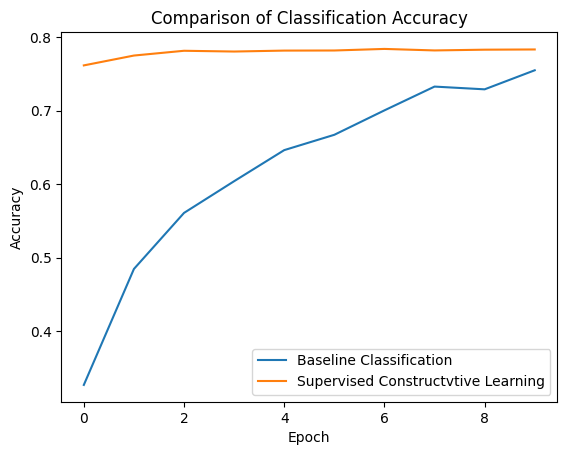

In [65]:
# Plot the accuracy curves for both models
import matplotlib.pyplot as plt

plt.plot(history.history["sparse_categorical_accuracy"], label="Baseline Classification")
plt.plot(history3.history["sparse_categorical_accuracy"], label="Supervised Constructvtive Learning")
plt.title("Comparison of Classification Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()



We can see that we use Supervised Constructive loss the starting and over all accuracy is much higher then out base case of using just the softmax layer.

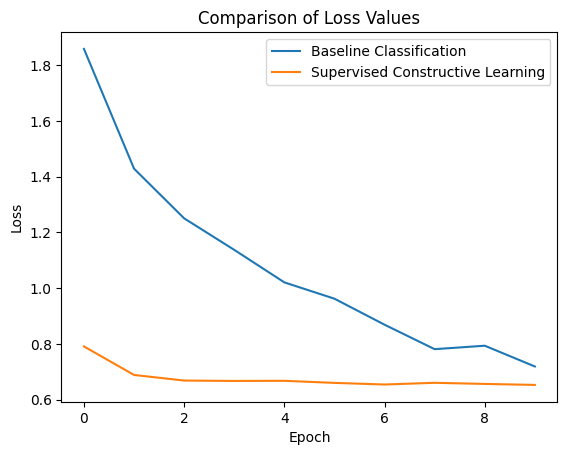

In [66]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Baseline Classification')
plt.plot(history3.history['loss'], label='Supervised Constructive Learning')
plt.title('Comparison of Loss Values')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


Reference:

1. https://keras.io/examples/vision/supervised-contrastive-learning/